In [52]:
!pip install transformers datasets --upgrade

In [53]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments

In [54]:
# Setup GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
from torch.utils.data import DataLoader, Dataset
class FAQDataSet(Dataset):
  def __init__(self, texts, faqs, university_names, tokenizer, max_length=512):
    self.texts = texts;
    self.faqs = faqs
    self.university_names = university_names
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, id):
    source_text = self.texts[id]
    target_text = self.faqs[id]
    university_name = self.university_names[id]

    source_encodings = self.tokenizer(source_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")
    target_encodings = self.tokenizer(target_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")

    return {
        'university_name': university_name,
        'input_ids': source_encodings['input_ids'].squeeze(0),
        'attention_mask': source_encodings['attention_mask'].squeeze(0),
        'labels': target_encodings['input_ids'].squeeze(0)
    }


In [56]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/data.csv')
data.fillna('No data available', inplace = True)
data['FAQs'] = data['FAQs'].apply(lambda ele: " ".join(ele.split(" | ")))
grouped_data = data.groupby('University Name').agg({'Admission Text': 'first', 'FAQs': ' '.join}).reset_index()
# train_data, val_data = train_test_split(grouped_data, test_size=0.1)
train_data, temp_val_data = train_test_split(grouped_data, test_size=0.2)
val_data, test_data = train_test_split(temp_val_data, test_size=0.5)

train_dataset = FAQDataSet(train_data['Admission Text'].tolist(), train_data['FAQs'].tolist(), train_data['University Name'].tolist(), tokenizer)
val_dataset = FAQDataSet(val_data['Admission Text'].tolist(), val_data['FAQs'].tolist(), val_data['University Name'].tolist(), tokenizer)
test_dataset = FAQDataSet(test_data['Admission Text'].tolist(), test_data['FAQs'].tolist(), test_data['University Name'].tolist(), tokenizer)


In [58]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory = True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory = True)

from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model.to(device)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 training loss: 8.3262, validation loss: 4.4076
Epoch 2 training loss: 3.2142, validation loss: 2.1995
Epoch 3 training loss: 1.6027, validation loss: 0.9532
Epoch 4 training loss: 0.8326, validation loss: 0.6079
Epoch 5 training loss: 0.6077, validation loss: 0.5356


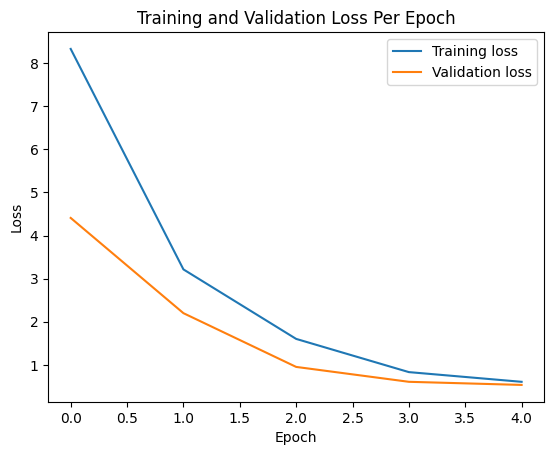

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./trained_bart_faq_generator/tokenizer_config.json',
 './trained_bart_faq_generator/special_tokens_map.json',
 './trained_bart_faq_generator/vocab.json',
 './trained_bart_faq_generator/merges.txt',
 './trained_bart_faq_generator/added_tokens.json')

In [59]:
training_losses = []
validation_losses = []

def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No need to compute gradient when evaluating
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Training loop
model.train()
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = evaluate_model(model, val_loader, device)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")

import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


model.save_pretrained('./trained_bart_faq_generator')
tokenizer.save_pretrained('./trained_bart_faq_generator')

In [60]:
def Faq_generation(model, tokenizer, context, max_length = 512):
  model.eval()
  inputs = tokenizer(context, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to(model.device)
  input_ids = inputs['input_ids'].to(model.device)
  attention_mask = inputs['attention_mask'].to(model.device)

  generated_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)

  generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

  return generated_text

In [61]:
!pip install rouge

In [62]:
generated_faqs = []
for i, row in test_data.iterrows():
    context = row['Admission Text']
    generated_faq = Faq_generation(model, tokenizer, context)
    generated_faqs.append(generated_faq)

reference_faqs = test_data['FAQs'].tolist()

from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(generated_faqs, reference_faqs, avg=True)

print("ROUGE-1:", scores['rouge-1']['f'])  # F1-score of ROUGE-1
print("ROUGE-2:", scores['rouge-2']['f'])  # F1-score of ROUGE-2
print("ROUGE-L:", scores['rouge-l']['f'])  # F1-score of ROUGE-L


ROUGE-1: 0.21082769305876153
ROUGE-2: 0.06398440612095323
ROUGE-L: 0.17287220315953608
